In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

In [42]:
def temp_ablation_plot(dataset, h, s,num_queries,
    temps = [0.01,0.1,0.5, 0.75, 1,1.25,1.75,2,3,4,5,10],):
    sub_est = [10,100,1000]
    # print(f"../data/temperature_ablation/{dataset}/val_dl/val-dl_{dataset}_temperature_ablation_*model-budget-bs*.pkl")
    # print(f"../data/temperature_ablation/{dataset}/val_dl/temp_pgt/val-dl_{dataset}_pseudo-gt*.pkl")
    pgt_paths = sorted(glob.glob(f"../data/temperature_ablation/{dataset}/val_dl/temp_pgt/val-dl_{dataset}_pseudo-gt*{num_queries}q.pkl"),
                      key = lambda pth: float(pth.split("_")[-3].replace('t','')))[2:]
    temps = [float(pth.split("_")[-3].replace('t','')) for pth in pgt_paths]
    bs_paths = sorted(glob.glob(f"../data/temperature_ablation/{dataset}/val_dl/val-dl_{dataset}_temperature-ablation_*model-budget-bs*{num_queries}q.pkl"),
                      key = lambda pth: float(pth.split("_")[-4].replace('t','')))[2:]
    is_paths = sorted(glob.glob(f"../data/temperature_ablation/{dataset}/val_dl/val-dl_{dataset}_temperature-ablation_*model-budget-imp-samp*{num_queries}q.pkl"),
                      key = lambda pth: float(pth.split("_")[-4].replace('t','')))[2:]
    # print(is_paths)
    # print(bs_paths)
    # print(pgt_paths)
    # asdf
    # print(pgt_paths)

    errors_list = []; dfs = []
    for pgt_path,bs_path,is_path,temp in zip(pgt_paths,bs_paths,is_paths,temps):
        pgt_data = read_pkl(pgt_path)
        bs_data = read_pkl(bs_path)
        is_data = read_pkl(is_path)
        pgt_est = torch.gather(pgt_data['sample_estimates'],1,pgt_data['excluded_terms'].unsqueeze(0)).squeeze()
        is_samples = torch.gather(is_data['sample_estimates'][:,-1,:],1,pgt_data['excluded_terms'].unsqueeze(0)).squeeze()
        bs_samples = torch.gather(bs_data['bs_lower_bound'][:,-1,:],1,pgt_data['excluded_terms'].unsqueeze(0)).squeeze()
        # print(is_samples.shape)
        # print(gt_est.shape)
        # print((is_samples == 0).sum()/is_samples.shape[0])
        # print(pgt_est[0], bs_samples[1], is_samples[1])
        bs_errors = torch.abs(pgt_est - bs_samples + 1e-5)/(pgt_est + 1e-5)
        # print(bs_samples[(bs_samples > pgt_est)])
        # print(bs_samples[bs_samples > pgt_est] - pgt_est[(bs_samples > pgt_est)])
        # print()
        is_errors = torch.abs(pgt_est - is_samples + 1e-5)/(pgt_est + 1e-5)
        # print((bs_errors == 1).sum())
        # errors_list.append((bs_errors,is_errors))
    
    # dfs = []
    # for (bs,imp),t in zip(errors_list,temps):
        # bs_data = pd.DataFrame(bs.numpy(),columns=['error'])
        # bs_data['est_type'] = 'beam_search'
        # is_data = pd.DataFrame(imp.numpy(),columns=['error'])
        # is_data['est_type'] = 'importance_sampling'

        df = pd.DataFrame(np.array([pgt_est.numpy(),is_samples.numpy(), bs_samples.numpy()]).T,columns = ['GT','IS','BS'])
        # df = pd.concat([bs_data,is_data],axis=0)
        df['temperature'] = temp
        df['sequence_id'] = list(range(pgt_est.shape[0]))
        dfs.append(df)
    # df['error'] = df['error'] + 1e-10
    df=pd.concat(dfs,axis=0)
    # df['error'] = np.log(df['error'] + 1e-10)
    return dataset,h,s,df,temps

In [43]:
dataset,h,s,df,temps = temp_ablation_plot('shakespeare',11,15,1000)
# temps = temps[2:]
print(temps)
df.shape

[0.5, 0.75, 1.0, 1.0, 1.25, 1.75, 2.0, 3.0, 4.0, 5.0, 10.0]


(11000, 5)

In [44]:
# df.to_csv('temp_ablation_shakespeare.csv',index=None)
final_df.shape

(26000, 3)

<ipython-input-48-c1b786fbd67d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bs_data['est_type'] = 'beam_search'
<ipython-input-48-c1b786fbd67d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_data['est_type'] = 'importance_sampling'
<ipython-input-48-c1b786fbd67d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

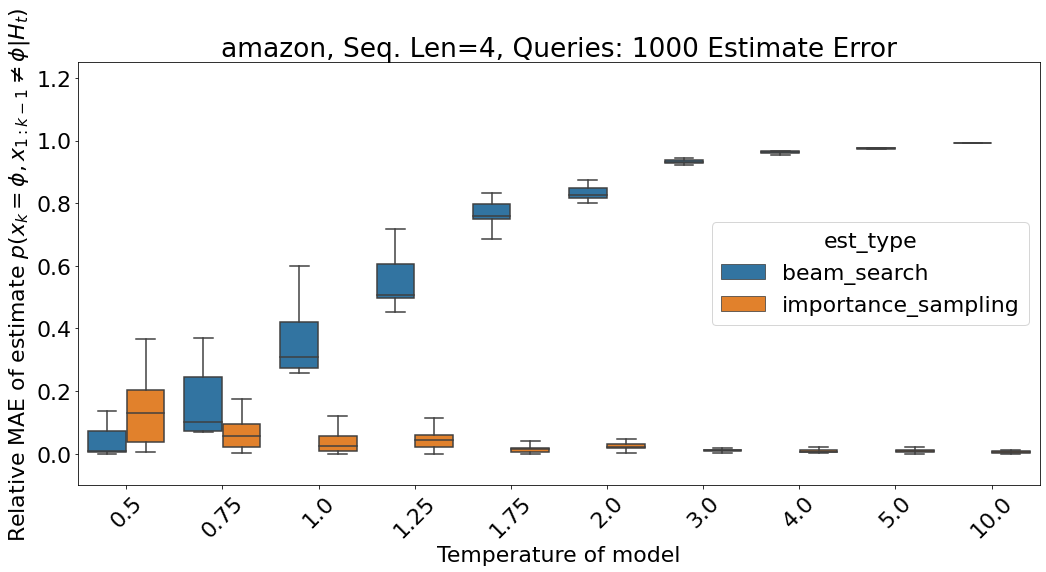

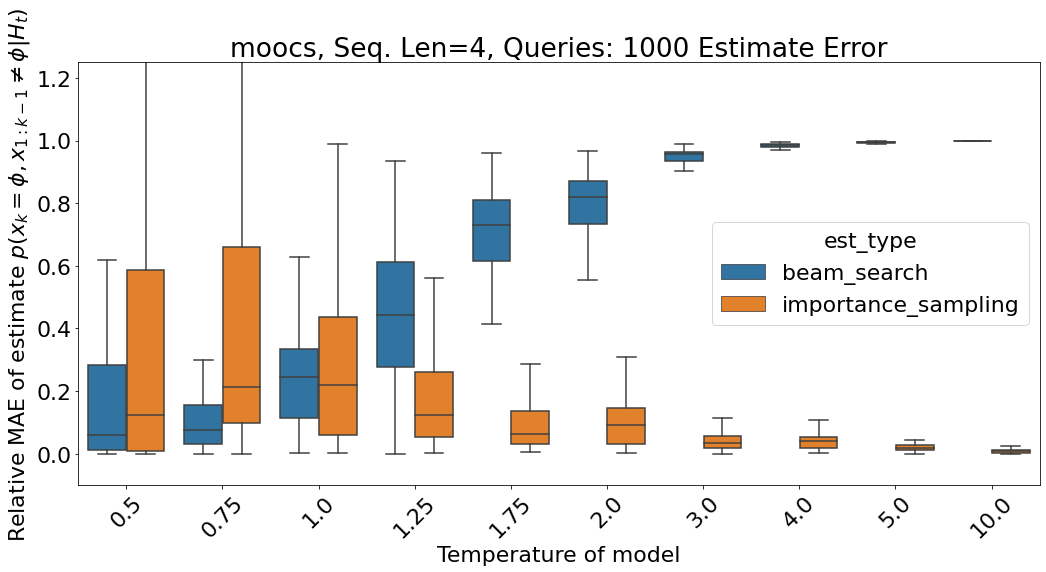

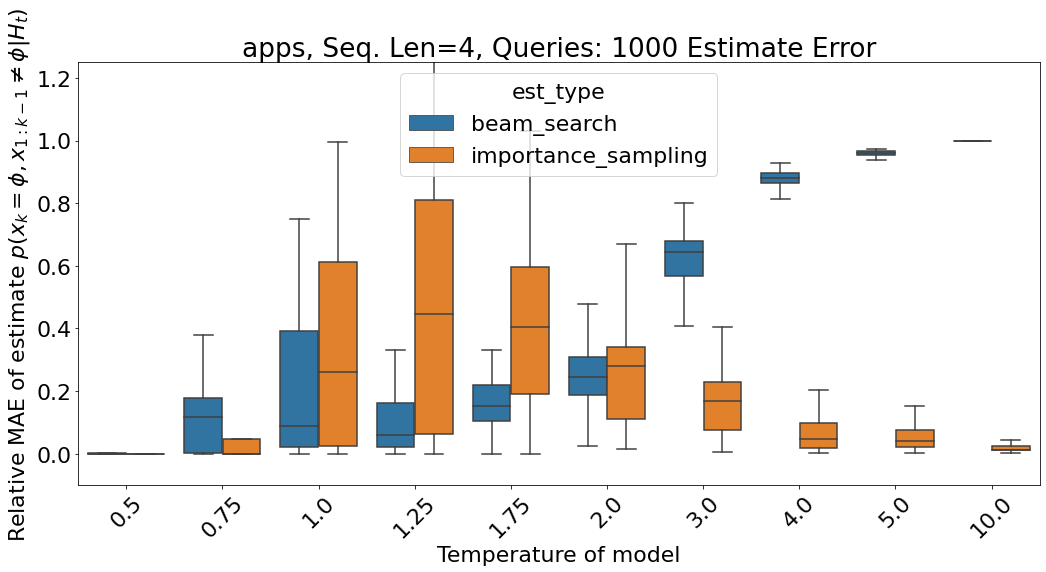

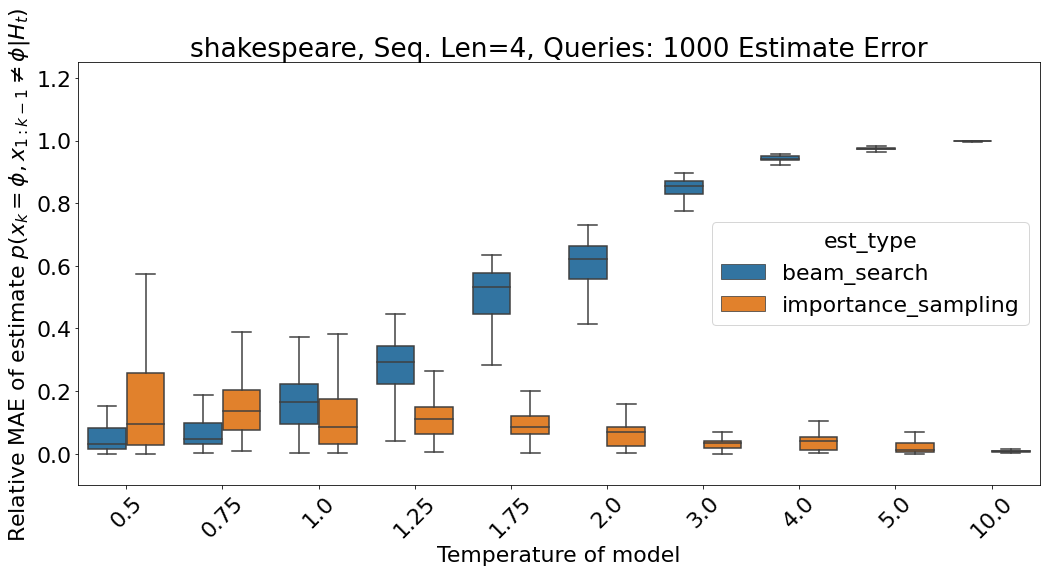

In [48]:
import matplotlib
datasets = ['amazon','moocs','apps','shakespeare']
lengths = [(11,15),(11,15),(11,15),(16,20)]
for dataset,(h,s) in zip(datasets,lengths):
    dataset,h,s,df,temps = temp_ablation_plot(dataset,h,s,1000)
    eps = 1e-6
    df['bs_error']= np.abs(df.GT - df.BS)/(df.GT + eps)
    df['is_error']= np.abs(df.GT - df.IS)/(df.GT + eps)
    bs_data = df[['temperature','bs_error']]
    bs_data.columns = ['temperature','error']
    bs_data['est_type'] = 'beam_search'
    is_data = df[['temperature','is_error']]
    is_data.columns = ['temperature','error']
    is_data['est_type'] = 'importance_sampling'
    final_df = pd.concat([bs_data,is_data],axis=0)
    # print(final_df.head())
    # print(final_df.isnull().sum())
    matplotlib.rcParams.update({'font.size': 22})
    fig,ax = plt.subplots(figsize=(15,8))
    # print("hi")
    # print(final_df.shape)
    # sns.lineplot(data=final_df, x="temperature", y="error", hue="est_type")
    # sns.lineplot(data=final_df, x="temperature", y="error")
    final_df.to_csv(f"{dataset}_temp_ablation_error.csv",index=None)
    sns.boxplot(x='temperature', y='error',data=final_df,fliersize=0,hue='est_type')
    # print("DONE")
    ax.set_xticklabels(sorted(final_df.temperature.drop_duplicates().values))
    plt.xlabel("Temperature of model")
    plt.ylabel(r"Relative MAE of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
    plt.title(f"{dataset}, Seq. Len={s-h}, Queries: 1000 Estimate Error")
    plt.xticks(rotation=45)
    plt.ylim(-0.1,1.25)
    plt.tight_layout()
    plt.savefig(f'temp_plot_{dataset}.pdf')